In [27]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import numpy as np
import random

# Set seed global untuk reproducibility
seed = 7
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Path dataset
dataset_dir = 'D:\\Semester 6\\AI\\Artificial_Inteligence\\PlantVillage'

In [28]:
# Parameter
batch_size = 16
img_size = (128, 128)

# Load data (resize otomatis)
full_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='int',
    shuffle=True,
    seed=seed  
)

# Ambil data dan label numpy
data, labels = [], []
for img_batch, label_batch in full_dataset:
    data.append(img_batch.numpy())
    labels.append(label_batch.numpy())
data = np.concatenate(data)
labels = np.concatenate(labels)

Found 2152 files belonging to 3 classes.


In [29]:
# Normalisasi data pixel dari [0,255] ke [0,1]
data = data / 255.0
data

array([[[[0.44705883, 0.4       , 0.4392157 ],
         [0.3764706 , 0.32941177, 0.36862746],
         [0.4       , 0.3529412 , 0.39215687],
         ...,
         [0.672549  , 0.6490196 , 0.6882353 ],
         [0.6745098 , 0.6509804 , 0.6901961 ],
         [0.68235296, 0.65882355, 0.69803923]],

        [[0.44607842, 0.3990196 , 0.43823528],
         [0.4137255 , 0.36666667, 0.40588236],
         [0.3882353 , 0.34117648, 0.38039216],
         ...,
         [0.66862744, 0.64509803, 0.6843137 ],
         [0.67156863, 0.6480392 , 0.6872549 ],
         [0.6754902 , 0.6519608 , 0.6911765 ]],

        [[0.45294118, 0.40588236, 0.44509804],
         [0.42647058, 0.37941176, 0.41862744],
         [0.38039216, 0.33333334, 0.37254903],
         ...,
         [0.6745098 , 0.6509804 , 0.6901961 ],
         [0.672549  , 0.6490196 , 0.6882353 ],
         [0.6745098 , 0.6509804 , 0.6901961 ]],

        ...,

        [[0.46078432, 0.42941177, 0.5117647 ],
         [0.4627451 , 0.43137255, 0.5137255 ]

In [30]:
# Split data jadi train 80%, val 10%, test 10%
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.2, random_state=seed, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed, shuffle=True)

In [ ]:
# Buat fungsi augmentasi sederhana (flip horizontal)
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    return image, label

# Buat tf.data.Dataset untuk train, val, test
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000, seed=seed).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

# Terapkan augmentasi hanya ke train dataset
train_dataset = train_dataset.map(augment)

In [32]:
# Prefetch untuk performa
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [34]:
# Definisikan model CNN 
input_shape = (128, 128, 3)
num_classes = 3

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

In [35]:
# Compile model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,027 (12.61 MB)

 Trainable params: 3,305,027 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
# Training model
epochs = 10
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs
)

Epoch 1/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 12s 89ms/step - accuracy: 0.6414 - loss: 0.7772 - val_accuracy: 0.8698 - val_loss: 0.3153
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 13s 124ms/step - accuracy: 0.8562 - loss: 0.3489 - val_accuracy: 0.9116 - val_loss: 0.2151
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 14s 133ms/step - accuracy: 0.9217 - loss: 0.2200 - val_accuracy: 0.9349 - val_loss: 0.2224
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 13s 117ms/step - accuracy: 0.9348 - loss: 0.1830 - val_accuracy: 0.9395 - val_loss: 0.1998
Epoch 5/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - accuracy: 0.9319 - loss: 0.1781 - val_accuracy: 0.9767 - val_loss: 0.0954
Epoch 6/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - accuracy: 0.9412 - loss: 0.1334 - val_accuracy: 0.9721 - val_loss: 0.0952
Epoch 7/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - accuracy: 0.9657 - loss: 0.0960 - val_accuracy: 0.9721 - val_loss: 0.0777
Epoch 8/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - accuracy: 0.9635 - loss: 0.

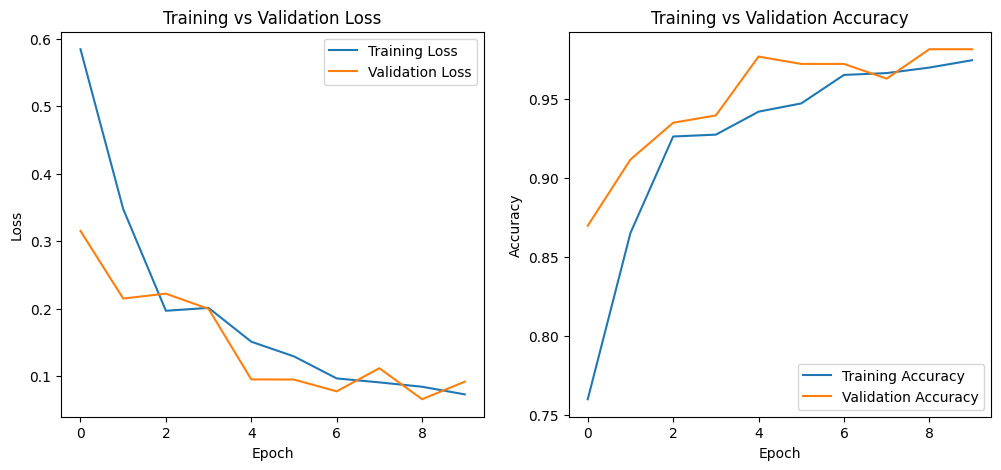

In [37]:
import matplotlib.pyplot as plt

# Plot loss dan accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [38]:
# Evaluasi model dengan test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {test_accuracy:.2f}")
print(f"Test loss: {test_loss:.2f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.9755 - loss: 0.0794
Test accuracy: 0.97
Test loss: 0.08


In [39]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Ambil class_names dari dataset training
class_names = full_dataset.class_names  # Ambil nama kelas dari dataset training

# Fungsi untuk memprediksi gambar baru dan menampilkan hasil prediksi
def predict_image_with_display(image_path, model, img_size=(128, 128)):
    # Memuat gambar dan mengubah ukurannya sesuai dengan model input
    img = image.load_img(image_path, target_size=img_size)
    img_array = image.img_to_array(img)  # Mengubah gambar menjadi array
    img_array = tf.expand_dims(img_array, 0)  # Menambahkan batch dimension

    # Melakukan prediksi dengan model
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])  # Mengambil kelas dengan probabilitas tertinggi
    confidence = np.max(predictions[0])  # Mengambil nilai probabilitas tertinggi

    # Menampilkan gambar dan hasil prediksi
    plt.imshow(img)  # Menampilkan gambar
    plt.axis('off')  # Menyembunyikan axis
    plt.title(f"Prediksi: {class_names[predicted_class]}\nConfidence: {confidence*100:.2f}%")
    plt.show()

    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


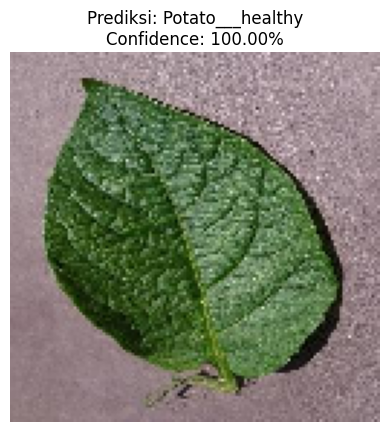

In [41]:
image_path = 'D:\\Semester 6\\AI\\Artificial_Inteligence\\new_images\\healthy2.jpg' 
predicted_index, confidence = predict_image_with_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


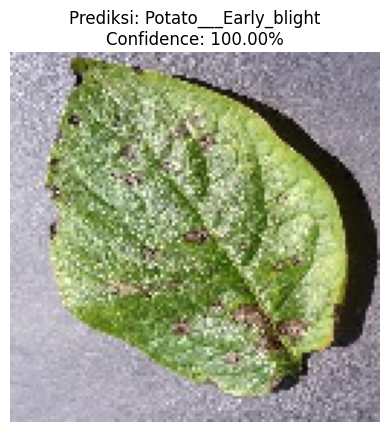

In [42]:
image_path = 'D:\\Semester 6\\AI\\Artificial_Inteligence\\new_images\\Early_blight.jpg'
predicted_index, confidence = predict_image_with_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


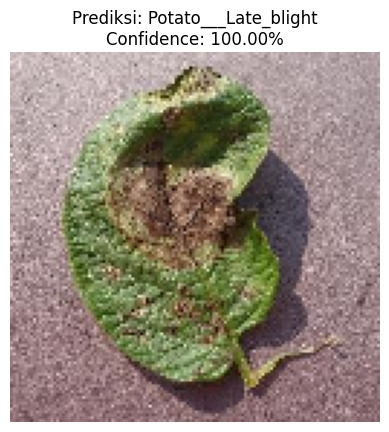

In [43]:
image_path = 'D:\\Semester 6\\AI\\Artificial_Inteligence\\new_images\\Late_blight2.jpg'
predicted_index, confidence = predict_image_with_display(image_path, model)
